In [1]:
!python -V

Python 3.9.12


## No queremos estar repitiendo la ejecución de este proceso celda por celda
---

Vamos a crear funciones para este proceso

In [2]:
# los más de los duros, los reales, los meros buenos
import pandas as pd
import numpy as np

# para graficar
import matplotlib.pyplot as plt
import seaborn as sns   

# libreria que usaremos para aprendizaje
import sklearn

# para preprocesamiento
from sklearn.feature_extraction import DictVectorizer

# los modelos
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

# las metricas
from sklearn.metrics import mean_squared_error

In [3]:
import mlflow
mlflow.__version__

'2.13.0'

In [9]:
mlflow.__version__

'2.13.0'

In [13]:
mlflow.set_tracking_uri('sqlite:///mlflowdB3.db')

In [15]:
mlflow.set_experiment('nyc-tracking-experiment-2')

2024/05/27 21:10:04 INFO mlflow.tracking.fluent: Experiment with name 'nyc-tracking-experiment-2' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/learning-mlops/mlruns/2', creation_time=1716844204954, experiment_id='2', last_update_time=1716844204954, lifecycle_stage='active', name='nyc-tracking-experiment-2', tags={}>

In [16]:
# la funcion para leer los datos
def leer_dataframe(filename):

    df = pd.read_parquet(filename)

    # parseamos el string a datetime
    
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime) 
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df["duration"] = df.duration.apply(lambda x: x.total_seconds()/60)

    df = df[(df.duration >= 1) & (df.duration <=60)]

    # convirtiendo la duracion a segundos
    
    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)

    return df
    

In [17]:
df_train = leer_dataframe('./01-intro/data/green_tripdata_2021-01.parquet')
df_val = leer_dataframe('./01-intro/data/green_tripdata_2021-02.parquet')
print(df_train.shape, df_val.shape)

(73908, 21) (61921, 21)


In [18]:
print(df_train.PULocationID.nunique())
print(df_train.DOLocationID.nunique())

250
256


In [19]:
print(df_val.PULocationID.nunique())
print(df_val.DOLocationID.nunique())

245
254


## Creando un nuevo feature
---

In [20]:
# creando un nuevo feature
df_train["PU_LO"] = df_train.PULocationID + '_' + df_train.DOLocationID
df_val["PU_LO"] = df_val.PULocationID + '_' + df_val.DOLocationID

In [21]:
categorical = ["PU_LO"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts) # OJO aqui solo usamos transform

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values


7.4793657829373155


/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


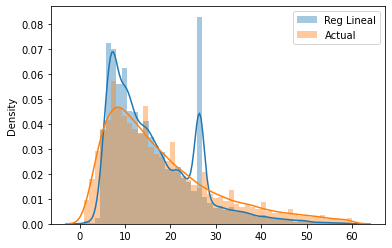

In [23]:
# entrenando Regresion Lineal
rl = LinearRegression()
rl.fit(X_train, y_train)

y_pred_rl = rl.predict(X_val)

print(mean_squared_error(y_val, y_pred_rl, squared=False))
sns.distplot(y_pred_rl, label='Reg Lineal')
sns.distplot(y_val, label='Actual')
plt.legend();

In [30]:
import pickle
with open("/workspaces/learning-mlops/02-exp-tracking/models/lin_reg2.bin", "wb") as f:
    pickle.dump((dv,rl), f)

9.233436225720547


/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


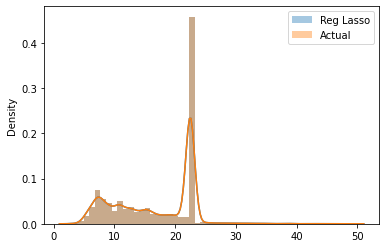

In [24]:
# entrenando Regresion Lineal
rl_lasso = Lasso(0.001)
rl_lasso.fit(X_train, y_train)

y_pred_lasso = rl_lasso.predict(X_val)

print(mean_squared_error(y_val, y_pred_lasso, squared=False))
sns.distplot(y_pred_lasso, label='Reg Lasso')
sns.distplot(y_pred_lasso, label='Actual')
plt.legend();

In [25]:
# Adding tracking

with mlflow.start_run():

    mlflow.set_tag('developer', 'carlos')
    mlflow.log_param('train-data-path', './01-intro/data/green_tripdata_2021-01.parquet')
    mlflow.log_param('validation-data-path', './01-intro/data/green_tripdata_2021-02.parquet')

    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    # entrenando Regresion Lineal
    rl_lasso = Lasso(alpha=alpha)
    rl_lasso.fit(X_train, y_train)

    y_pred_lasso = rl_lasso.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred_lasso, squared=False)
    mlflow.log_metric('rmse', rmse)

Finished [MLOps Zoomcamp 2.2 - Getting started with MLflow](https://www.youtube.com/watch?v=cESCQE9J3ZE&list=PL3MmuxUbc_hIUISrluw_A7wDSmfOhErJK&index=10)

## Optimizando hiperparametros de un XGBOOST con hyperopt
---


In [26]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [28]:
# creating the train and test set
xgb_train_set = xgb.DMatrix(X_train, label=y_train)
xgb_val_set = xgb.DMatrix(X_val, label=y_val)

In [29]:
# primero tenemos que definir la funcion objetivo

def funcion_objetivo(parametros, train_set=xgb_train_set, validation_set=xgb_val_set):

    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(parametros)

        xg = xgb.train(
            params=parametros,
            dtrain=train_set,
            num_boost_round=1000,
            evals=[(validation_set,"validation")],
            early_stopping_rounds=50
        )

        y_pred = xg.predict(validation_set)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {"loss": rmse, "status": STATUS_OK}

In [30]:
search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", -3, 0), # exp(-3) hasta exp(0) - (0.05, 1.0)
    "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
    "reg_lambda": hp.loguniform("reg_lambda", -6, -1),
    "min_child_weight": hp.loguniform("min_child_weight", -1, 3),
    "objective": "reg:linear",
    "seed": 42,
}

In [31]:
best_result = fmin(
    fn=funcion_objetivo,
    space=search_space,
    algo=tpe.suggest,
    max_evals=3,
    trials=Trials()
)

[21:28:37] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.                                                                                            
[0]	validation-rmse:19.70649                                                                                                                                                                                      
[1]	validation-rmse:18.35578                                                                                                                                                                                      
[2]	validation-rmse:17.12939                                                                                                                                                                                      
[3]	validation-rmse:16.01795                                                                                                                                

Now that we have the best parameters we can train the best model

In [32]:
mlflow.xgboost.autolog()

In [33]:
## Choosing the best parameters
best_params = {
"learning_rate": 0.11665465693180731,
"max_depth": 39,
"min_child_weight": 1.699112908194548,
"objective": "reg:linear",
"reg_alpha": 0.0877938168395368,
"reg_lambda": 0.26227785341843785
}

mlflow.xgboost.autolog()


xg = xgb.train(
    params=best_params,
    dtrain=xgb_train_set,
    num_boost_round=100,
    evals=[(xgb_val_set,"validation")],
    early_stopping_rounds=50
)

2024/05/27 21:37:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd87ef1d4c406479fb5a0e71738afb3db', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2024/05/27 21:37:52 WARNING mlflow.xgboost: Unable to log dataset information to MLflow Tracking.XGBoost version must be >= 1.7.0
2024/05/27 21:37:52 WARNING mlflow.xgboost: Unable to log dataset information to MLflow Tracking.XGBoost version must be >= 1.7.0


[21:37:52] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.10690
[1]	validation-rmse:17.29069
[2]	validation-rmse:15.71108
[3]	validation-rmse:14.34112
[4]	validation-rmse:13.15956
[5]	validation-rmse:12.14354
[6]	validation-rmse:11.27300
[7]	validation-rmse:10.52887
[8]	validation-rmse:9.89523
[9]	validation-rmse:9.35700
[10]	validation-rmse:8.90500
[11]	validation-rmse:8.52353
[12]	validation-rmse:8.20128
[13]	validation-rmse:7.92971
[14]	validation-rmse:7.70468
[15]	validation-rmse:7.51429
[16]	validation-rmse:7.35484
[17]	validation-rmse:7.22239
[18]	validation-rmse:7.11004
[19]	validation-rmse:7.01559
[20]	validation-rmse:6.93572
[21]	validation-rmse:6.86875
[22]	validation-rmse:6.81142
[23]	validation-rmse:6.76311
[24]	validation-rmse:6.72134
[25]	validation-rmse:6.68556
[26]	validation-rmse:6.65546
[27]	validation-rmse:6.62820
[28]	validation-rmse:6.60599
[29]	validation-rmse:6.58667
[30]	validati

2024/05/27 21:38:22 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/27 21:38:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils."


Finished 3rd Video

[MLOps Zoomcamp 2.3 - Experiment tracking with MLflow](https://www.youtube.com/watch?v=iaJz-T7VWec&list=PL3MmuxUbc_hIUISrluw_A7wDSmfOhErJK&index=11)

## 4th Video

Guardando el modelo como artefacto

In [43]:
# Adding tracking
# THIS WORKED

with mlflow.start_run():

    mlflow.set_tag('developer', 'carlos')
    mlflow.log_param('train-data-path', './01-intro/data/green_tripdata_2021-01.parquet')
    mlflow.log_param('validation-data-path', './01-intro/data/green_tripdata_2021-02.parquet')

    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    # entrenando Regresion Lineal
    rl_lasso = Lasso(alpha=alpha)
    rl_lasso.fit(X_train, y_train)

    y_pred_lasso = rl_lasso.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred_lasso, squared=False)
    mlflow.log_metric('rmse', rmse)

    mlflow.log_artifact(local_path='/workspaces/learning-mlops/models/lin_reg_bin.bin', artifact_path='models_pickle')

Debería haber una manera de guardar modelos de manerea tal que sea fácil usarlos en el futuro.

Segunda manera de guardar modelos con MLFlow.

In [44]:
with mlflow.start_run():

    ## Choosing the best parameters
    best_params = {
    "learning_rate": 0.11665465693180731,
    "max_depth": 39,
    "min_child_weight": 1.699112908194548,
    "objective": "reg:linear",
    "reg_alpha": 0.0877938168395368,
    "reg_lambda": 0.26227785341843785,
    "seed":42
    }

    mlflow.log_params(best_params)

    xg = xgb.train(
        params=best_params,
        dtrain=xgb_train_set,
        num_boost_round=100,
        evals=[(xgb_val_set,"validation")],
        early_stopping_rounds=50
    )

    y_pred = xg.predict(xgb_val_set)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)

    mlflow.xgboost.log_model(xg, artifact_path='xgboost_models_mlflow')


2024/05/27 22:35:17 WARNING mlflow.xgboost: Unable to log dataset information to MLflow Tracking.XGBoost version must be >= 1.7.0
2024/05/27 22:35:17 WARNING mlflow.xgboost: Unable to log dataset information to MLflow Tracking.XGBoost version must be >= 1.7.0


[22:35:17] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.10690
[1]	validation-rmse:17.29069
[2]	validation-rmse:15.71108
[3]	validation-rmse:14.34112
[4]	validation-rmse:13.15956
[5]	validation-rmse:12.14354
[6]	validation-rmse:11.27300
[7]	validation-rmse:10.52887
[8]	validation-rmse:9.89523
[9]	validation-rmse:9.35700
[10]	validation-rmse:8.90500
[11]	validation-rmse:8.52353
[12]	validation-rmse:8.20128
[13]	validation-rmse:7.92971
[14]	validation-rmse:7.70468
[15]	validation-rmse:7.51429
[16]	validation-rmse:7.35484
[17]	validation-rmse:7.22239
[18]	validation-rmse:7.11004
[19]	validation-rmse:7.01559
[20]	validation-rmse:6.93572
[21]	validation-rmse:6.86875
[22]	validation-rmse:6.81142
[23]	validation-rmse:6.76311
[24]	validation-rmse:6.72134
[25]	validation-rmse:6.68556
[26]	validation-rmse:6.65546
[27]	validation-rmse:6.62820
[28]	validation-rmse:6.60599
[29]	validation-rmse:6.58667
[30]	validati

2024/05/27 22:35:48 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.


`It is a good idea to save the preprocessor`

In [45]:
# disabling the autologger
mlflow.xgboost.autolog(disable=True)

In [47]:
import pickle

In [48]:
# THIS WORKS

with mlflow.start_run():

    ## Choosing the best parameters
    best_params = {
    "learning_rate": 0.11665465693180731,
    "max_depth": 39,
    "min_child_weight": 1.699112908194548,
    "objective": "reg:linear",
    "reg_alpha": 0.0877938168395368,
    "reg_lambda": 0.26227785341843785,
    "seed":42
    }

    mlflow.log_params(best_params)

    xg = xgb.train(
        params=best_params,
        dtrain=xgb_train_set,
        num_boost_round=100,
        evals=[(xgb_val_set,"validation")],
        early_stopping_rounds=50
    )

    y_pred = xg.predict(xgb_val_set)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)
    
    with open('/workspaces/learning-mlops/models/preprocessor.b', 'wb') as f:
        pickle.dump(dv, f)

    mlflow.log_artifact(local_path='/workspaces/learning-mlops/models/preprocessor.b', artifact_path='preprocessor')

    mlflow.xgboost.log_model(xg, artifact_path='xgboost_models_mlflow')


[22:42:20] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.10690
[1]	validation-rmse:17.29069
[2]	validation-rmse:15.71108
[3]	validation-rmse:14.34112
[4]	validation-rmse:13.15956
[5]	validation-rmse:12.14354
[6]	validation-rmse:11.27300
[7]	validation-rmse:10.52887
[8]	validation-rmse:9.89523
[9]	validation-rmse:9.35700
[10]	validation-rmse:8.90500
[11]	validation-rmse:8.52353
[12]	validation-rmse:8.20128
[13]	validation-rmse:7.92971
[14]	validation-rmse:7.70468
[15]	validation-rmse:7.51429
[16]	validation-rmse:7.35484
[17]	validation-rmse:7.22239
[18]	validation-rmse:7.11004
[19]	validation-rmse:7.01559
[20]	validation-rmse:6.93572
[21]	validation-rmse:6.86875
[22]	validation-rmse:6.81142
[23]	validation-rmse:6.76311
[24]	validation-rmse:6.72134
[25]	validation-rmse:6.68556
[26]	validation-rmse:6.65546
[27]	validation-rmse:6.62820
[28]	validation-rmse:6.60599
[29]	validation-rmse:6.58667
[30]	validati

Cargando el modelo

In [49]:
import mlflow
logged_model = 'runs:/9af63424b46845238efc15453cbc68e4/xgboost_models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

[22:45:10] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [50]:
loaded_model # esto es una funcion de python

mlflow.pyfunc.loaded_model:
  artifact_path: xgboost_models_mlflow
  flavor: mlflow.xgboost
  run_id: 9af63424b46845238efc15453cbc68e4

In [51]:
# tambien podemos cargarlo en el flavor de XGB
loaded_xgboost_model = mlflow.xgboost.load_model(logged_model)

[22:46:23] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [52]:
loaded_xgboost_model # this is an xgboost object

Making predictions

In [53]:
y_pred_from_loaded = loaded_xgboost_model.predict(xgb_val_set)

In [54]:
mean_squared_error(y_val, y_pred_from_loaded, squared=False)

6.405774342600602

Finished 4th video

[Model Management](https://www.youtube.com/watch?v=OVUPIX88q88&list=PL3MmuxUbc_hIUISrluw_A7wDSmfOhErJK&index=12)